# **Study of the paper: PNP-flow**

### Project by: Sara Meziane and Mariia Baranova

This notebook is based on the Demo notebook from the GitHub associated to the article : https://github.com/annegnx/PnP-Flow . To run the notebook it is necessary to download "models.py" from "pnpflow" folder of this repository.

We have tested several inverse problems with different parameters: denoising, deblurring, inpainting from a big mask or randomply masked pixels, tested different hyper-parameters.

In the last part, we have replaced the proposed flow denoiser with a Drunet to compare the performance.

In [2]:
from IPython.display import display, clear_output
import torch.nn.functional as F
from models import UNet
from PIL import Image
import torch
import torchvision.transforms as v2
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import torch.nn as nn
import torch.optim as optim
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

### PSNR metric

In [4]:
def psnr(uref,ut,M=1):
    rmse = np.sqrt(np.mean((np.array(uref.cpu())-np.array(ut.cpu()))**2))
    return 20*np.log10(M/rmse)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Load test image and define different inverse problems**

In [7]:
image_path = 'example.jpg'
#image_path = "000038.jpg"
clean_img = Image.open(image_path)

# Define the transformation
transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((128,128)),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply the transformation
clean_img = transform(clean_img).unsqueeze(0).to(device)

In [18]:
# Inverse pb 1 : Adding noise and masking random pixels (we have tried different quantities of masked pixels)
#-----------------------------------------
# Create a random mask with 70% missing pixels

def psnr(uref,ut,M=1):
    rmse = np.sqrt(np.mean((np.array(uref.cpu())-np.array(ut.cpu()))**2))
    return 20*np.log10(M/rmse)

# no masking
mask = np.ones((128,128))

mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(
    0).unsqueeze(0).to(device)


# define the linear operator H
def H(x):
    return x*mask_tensor

# Apply the mask to the image tensor and add noise
sigma_noise = 0.2
#sigma_noise = 0.001
noisy_img = H(clean_img) + sigma_noise * torch.randn_like(clean_img)
#noisy_img = clean_img + sigma_noise * torch.randn_like(clean_img) #only noise without mask

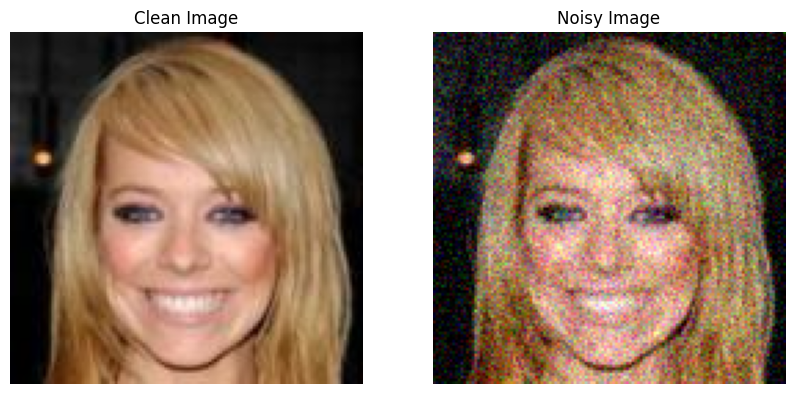

13.972445


In [19]:
# plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torch.clip((clean_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
plt.axis('off')
plt.title('Clean Image')
plt.subplot(1, 2, 2)
plt.imshow(torch.clip((noisy_img[0].cpu() + 1) /
           2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title('Noisy Image')
plt.show()

print(psnr(clean_img,noisy_img))

In [22]:
# Inverse pb 2 : Adding blur
#---------------------------------------
sigma_noise = 0.05 # let it fixed
sigma_blur = 5 # we vary this parameter

# Define the Gaussian kernel
def gaussian_kernel(kernel_size=5, sigma=1.0):
    # Create an evenly spaced grid for x and y values
    kernel = torch.zeros((kernel_size, kernel_size))
    center = kernel_size // 2

    for x in range(kernel_size):
        for y in range(kernel_size):
            kernel[x, y] = torch.exp(-0.5 * ((torch.tensor(x) - center)**2 + (torch.tensor(y) - center)**2) / (sigma**2))

    kernel = kernel / kernel.sum()
    return kernel

# Apply Gaussian Blur (kernel size = 5, sigma = sigma_blur)
def apply_blur(img, kernel_size=5, sigma=sigma_blur):
    # Generate the kernel
    kernel = gaussian_kernel(kernel_size, sigma).unsqueeze(0).unsqueeze(0).to(img.device)
    kernel = kernel.expand(img.shape[1], 1, kernel_size, kernel_size)
    # Apply the convolution (blur)
    blurred_img = F.conv2d(img, kernel, padding=kernel_size//2, groups=img.shape[1])

    return blurred_img

blurred_img = apply_blur(clean_img)+sigma_noise * torch.randn_like(clean_img)


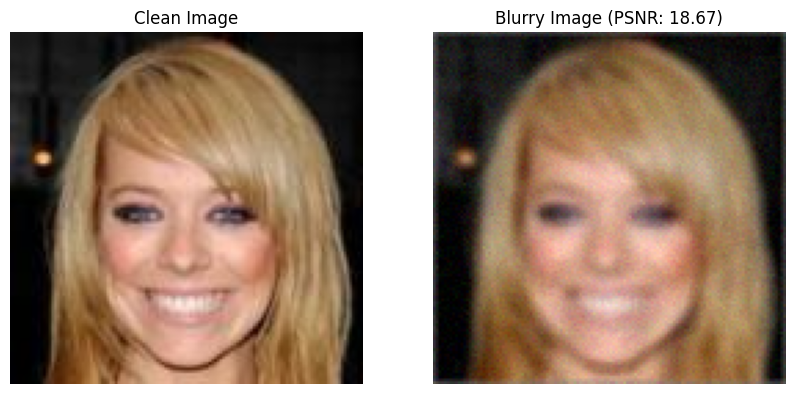

In [23]:
psnr_blurred = psnr(clean_img, blurred_img)


plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torch.clip((clean_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
plt.axis('off')
plt.title('Clean Image')
plt.subplot(1, 2, 2)
plt.imshow(torch.clip((blurred_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title(f'Blurry Image (PSNR: {psnr_blurred:.2f})')

plt.show()


In [25]:
# Inverse pb 3 : Add a big mask in the middle
#---------------------------------------
# Create a mask of ones (no masking)
mask = np.ones((128, 128))

# Define a central square mask (inpainting)
mask[32:110, 32:110] = 0  # Set the central region to 0 (masked)

# Convert to tensor
mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# Define the linear operator H (applies the mask)
def H(x):
    return x * mask_tensor

# Apply the mask to the image tensor and add noise

sigma_noise = 0.001
masked_img = H(clean_img) + sigma_noise * torch.randn_like(clean_img)

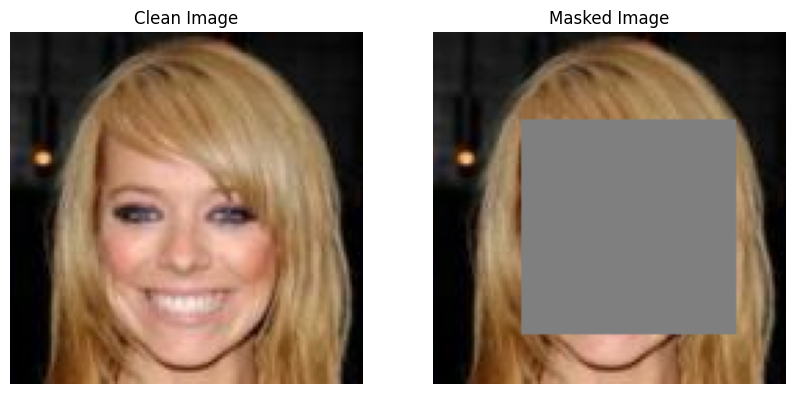

In [26]:
# plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torch.clip((clean_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
plt.axis('off')
plt.title('Clean Image')
plt.subplot(1, 2, 2)
plt.imshow(torch.clip((masked_img[0].cpu() + 1) /
           2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title('Masked Image')
plt.show()

## **Part 1 : Restore with PnP-flow**

### Pre-trained velocity field from pnpflow/models.py of the original GitHub

In [ ]:
!pip install gdown
!gdown --id 1ZZ6S-PGRx-tOPkr4Gt3A6RN-PChabnD6

In [ ]:
model = UNet(input_channels=3,
             input_height=128,
             ch=32,
             ch_mult=(1, 2, 4, 8),
             num_res_blocks=6,
             attn_resolutions=(16, 8),
             resamp_with_conv=True,
             )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('model_final_celeba.pt', map_location=device))
model.to(device)
model.eval()

### Define denoiser

In [16]:
def denoiser(x, t):
    return x + (1 - t.view(-1, 1, 1, 1)) * model(x, t)

### Run PnP-Flow for denoising (after running the Inverse pb 1)

16.396244


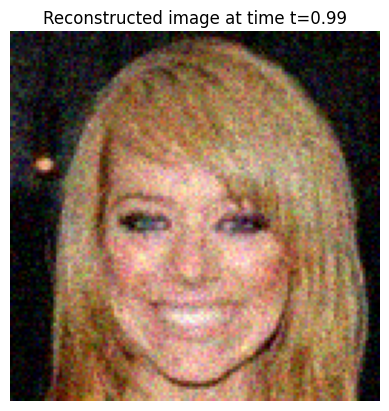

In [21]:
N = 100  # Number of time steps
alpha = 0.2  # Exponent in the learning rate (try different values)
delta = 1 / N  # Time step size
x = torch.zeros((1, 3, 128, 128)).to(device)
fig, ax = plt.subplots()

for i in range(N):

    with torch.no_grad():

        t = torch.ones(len(x), device=device) * delta * i

        # Gradient step on the data-fidelity term
        lr_t = (1 - t)**alpha
        z = x - lr_t * H(H(x) - noisy_img)  # H is symmetric

        # Interpolation step
        z_tilde = t.view(-1, 1, 1, 1) * z + \
            torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

        # Denoising step
        x_new = denoiser(z_tilde, t)

        # Update the solution
        x = x_new.clone()

        # Plot the current image
        if i % 5 == 0 or i == N - 1:
            clear_output(wait=True)
            ax.imshow(torch.clip((x[0].cpu() + 1) / 2,
                      0, 1).permute(1, 2, 0), vmin=0, vmax=1)
            ax.axis('off')
            ax.set_title(
                'Reconstructed image at time t={:4.2f}'.format(delta * i))
            display(fig)
            print(psnr(clean_img,x))

clear_output(wait=False)
print(psnr(clean_img,x))

## Run PnP-Flow for deblurring (after running Inverse pb 2)

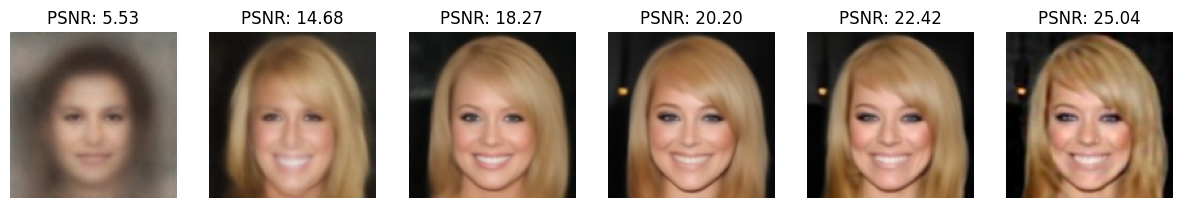

In [24]:
N = 100  # Number of time steps
alpha = 0.01  # Exponent in the learning rate (try different values)
delta = 1 / N  # Time step size
x = torch.zeros((1, 3, 128, 128)).to(device)  # Initialize with zeros

# Store images and PSNR values
saved_images = []
psnr_values = []

# Define H (blurring) and H^T (transpose, which is the same for symmetric Gaussian blur)
def H(img):
    return apply_blur(img, kernel_size=5, sigma=sigma_blur)

def H_T(img):
    return apply_blur(img, kernel_size=5, sigma=sigma_blur)  # Gaussian blur is symmetric

for i in range(N):
    with torch.no_grad():
        t = torch.ones(len(x), device=device) * delta * i

        # Gradient step on the data-fidelity term for deblurring
        lr_t = (1 - t) ** alpha
        z = x - lr_t * H_T(H(x) - blurred_img)

        # Interpolation step
        z_tilde = t.view(-1, 1, 1, 1) * z + torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

        # Denoising step
        x_new = denoiser(z_tilde, t)

        # Update the solution
        x = x_new.clone()

        # Save images and PSNR at each 20th step and the last step
        if i % 20 == 0 or i == N - 1:
            saved_images.append(x[0].cpu())  # Store the tensor image
            psnr_values.append(psnr(clean_img, x))  # Compute and store PSNR

# Plot all saved images side by side
fig, axes = plt.subplots(1, len(saved_images), figsize=(15, 5))

for idx, (img, psnr_val) in enumerate(zip(saved_images, psnr_values)):
    axes[idx].imshow(torch.clip((img + 1) / 2, 0, 1).permute(1, 2, 0))
    axes[idx].axis("off")
    axes[idx].set_title(f"PSNR: {psnr_val:.2f}")

plt.show()


## Run PnP-Flow for deblurring (after running Inverse pb 3)

18.000046


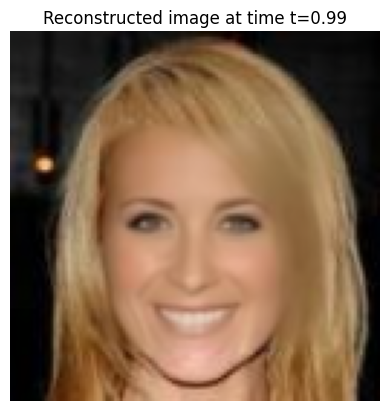

In [28]:
N = 100  # Number of time steps
alpha = 0.01  # Exponent in the learning rate
delta = 1 / N  # Time step size
x = torch.zeros((1, 3, 128, 128)).to(device)
fig, ax = plt.subplots()

for i in range(N):

    with torch.no_grad():

        t = torch.ones(len(x), device=device) * delta * i

        # Gradient step on the data-fidelity term
        lr_t = (1 - t)**alpha
        z = x - lr_t * H(H(x) - masked_img)  # H is symmetric

        # Interpolation step
        z_tilde = t.view(-1, 1, 1, 1) * z + \
            torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

        # Denoising step
        x_new = denoiser(z_tilde, t)

        # Update the solution
        x = x_new.clone()

        # Plot the current image
        if i % 5 == 0 or i == N - 1:
            clear_output(wait=True)
            ax.imshow(torch.clip((x[0].cpu() + 1) / 2,
                      0, 1).permute(1, 2, 0), vmin=0, vmax=1)
            ax.axis('off')
            ax.set_title(
                'Reconstructed image at time t={:4.2f}'.format(delta * i))
            display(fig)

clear_output(wait=False)
print(psnr(clean_img,x))

We observe that the face was not restored accurately.

## **Part 2 : Restore with DruNet and replace Denoiser in PnP-Flow by DruNet**

In [ ]:
!pip install git+https://github.com/deepinv/deepinv.git#egg=deepinv

In [31]:
# Load the model with original weights
import deepinv as dinv
denoiser_drunet = dinv.models.DRUNet().to(device).eval()

Downloading: "https://huggingface.co/deepinv/drunet/resolve/main/drunet_deepinv_color_finetune_22k.pth?download=true" to /root/.cache/torch/hub/checkpoints/drunet_deepinv_color_finetune_22k.pth
100%|██████████| 125M/125M [00:00<00:00, 144MB/s]


## Denoising with Drunet (re-run Inverse pb 1)

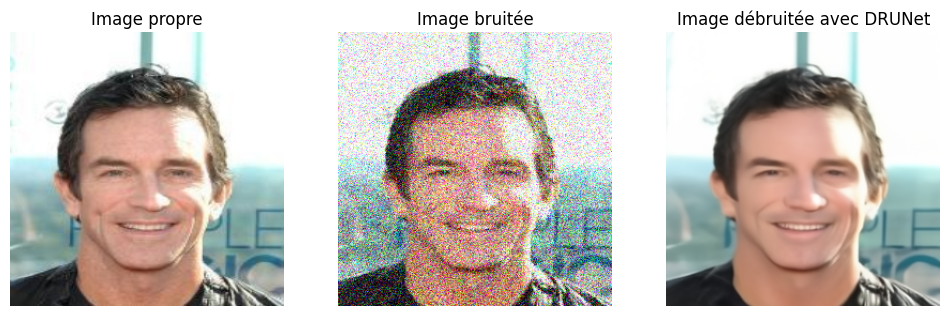

In [ ]:
image_path = "000038.jpg"
image = Image.open(image_path).convert("RGB")

# Transformer l’image pour être compatible avec DRUNet
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

x_clean = transform(image).unsqueeze(0).to(device)  # Ajouter batch dimension et envoyer sur GPU

sigma = 0.2  # Bruit de variance 25
noise = torch.randn_like(x_clean).to(device) * sigma
mask = np.random.rand(256, 256)
mask = np.ones((256,256))
mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(
    0).unsqueeze(0).to(device)
def H(x):
    return x*mask_tensor

x_noisy = H(x_clean) + noise  # Image bruitée

with torch.no_grad():
    x_denoised = denoiser_drunet(x_noisy, torch.tensor([sigma]).to(device))

def show_images(img_list, titles):
    fig, ax = plt.subplots(1, len(img_list), figsize=(12, 4))
    for i, img in enumerate(img_list):
        ax[i].imshow(img)
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    plt.show()

# Convertir les images pour affichage
def tensor_to_image(tensor):
    img = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    return img.clip(0, 1)  # Garder les valeurs entre [0,1]

img_clean = tensor_to_image(x_clean)
img_noisy = tensor_to_image(x_noisy)
img_denoised = tensor_to_image(x_denoised)

show_images([img_clean, img_noisy, img_denoised], ["Image propre", "Image bruitée", "Image débruitée avec DRUNet"])


### Replacing the flow denoiser with Drunet :

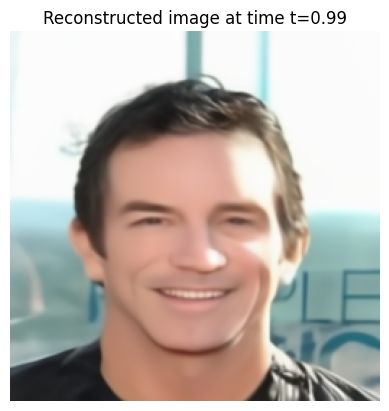

In [ ]:
N = 100  # Number of time steps
alpha = 0.01  # Exponent in the learning rate
delta = 1 / N  # Time step size
x = torch.zeros((1, 3, 256, 256)).to(device)
fig, ax = plt.subplots()
save_dir = "output_images"
for i in range(N):

    with torch.no_grad():

        t = torch.ones(len(x), device=device) * delta * i

        # Gradient step on the data-fidelity term
        lr_t = (1 - t)**alpha
        z = x - lr_t * H(H(x) - x_noisy)  # H is symmetric

        # Interpolation step
        z_tilde = t.view(-1, 1, 1, 1) * z + \
            torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

        # Denoising step
        x_new = denoiser_drunet(z_tilde,sigma=torch.tensor([0.2]).to(device))

        # Update the solution
        x = x_new.clone()

        # Plot the current image
        if i % 20 == 0 or i == N - 1:
            clear_output(wait=True)
            #ax.imshow(torch.clip((x[0].cpu() + 1) / 2,
            #         0, 1).permute(1, 2, 0), vmin=0, vmax=1)
            ax.imshow(tensor_to_image(x))
            ax.axis('off')
            ax.set_title(
                'Reconstructed image at time t={:4.2f}'.format(delta * i))
            display(fig)
            res = psnr(x_clean,x)
            print(res)
            #save_path = os.path.join(save_dir, f"New_PNP_t{i:03d}_alpha{alpha}_PSNR{res}.png")
            #fig.savefig(save_path, bbox_inches='tight')

clear_output(wait=False)
#print(psnr(clean_img,x))

## Replacing the flow denoiser with DruNet in deblurring task

We didn't obtain a good result here.

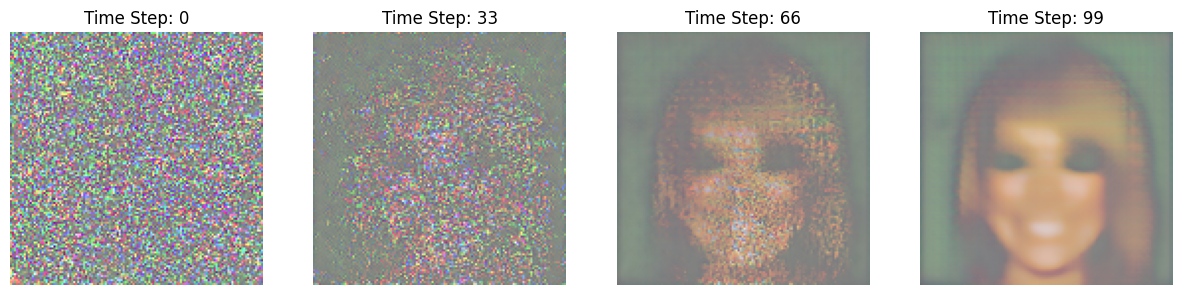

In [34]:
N = 100  # Number of time steps
alpha = 0.01  # Exponent in the learning rate
delta = 1 / N  # Time step size
x = torch.zeros((1, 3, 128, 128)).to(device)  # Initialize with zeros

# Store images and corresponding time steps
saved_images = []
time_steps = []

def H(img):
    return apply_blur(img, kernel_size=5, sigma=sigma_blur)

def H_T(img):
    return apply_blur(img, kernel_size=5, sigma=sigma_blur)  # Gaussian blur is symmetric

save_steps = [0, N//3, 2*N//3, N-1]

for i in range(N):
    with torch.no_grad():
        t = torch.ones(len(x), device=device) * delta * i

        # Gradient step on the data-fidelity term for deblurring
        lr_t = (1 - t) ** alpha
        z = x - lr_t * H_T(H(x) - blurred_img)

        # Interpolation step
        z_tilde = t.view(-1, 1, 1, 1) * z + torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

        # Denoising step
        x_new = denoiser_drunet(z_tilde,sigma=torch.tensor([0.2]).to(device))

        # Update the solution
        x = x_new.clone()

        # Save images at selected time steps
        if i in save_steps:
            saved_images.append(x[0].cpu())  # Store the tensor image
            time_steps.append(i)  # Store the time step

# Plot all saved images side by side
fig, axes = plt.subplots(1, len(saved_images), figsize=(15, 5))

for idx, (img, t_step) in enumerate(zip(saved_images, time_steps)):
    axes[idx].imshow(torch.clip((img + 1) / 2, 0, 1).permute(1, 2, 0))
    axes[idx].axis("off")
    axes[idx].set_title(f"Time Step: {t_step}")

plt.show()


### **Training of Drunet on a small subset of CelebA**

Originally we trained Drunet on a small subset of celebA. Even though the loss decreased, the training was really slow and not that efficient since the subset was small. We also noticed that Drunet with original weights performed already well.

In [ ]:
# Download and extract CelebA
#--------------------------------------------------------------------
dataset = datasets.CelebA(root="data", split="train", download=True)

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import randoms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load CelebA dataset with transformations
celeba_dataset = datasets.CelebA(root="data", split="train", transform=transform, download=True)

subset_size = 5000
indices = random.sample(range(len(celeba_dataset)), subset_size)
subset = Subset(celeba_dataset, indices)
batch_size = 16
# Create DataLoader for subset
subset_dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
!pip install git+https://github.com/deepinv/deepinv.git#egg=deepinv

In [ ]:
# Training pipeline (with Lipschitz penalty)
#-----------------------------------------------------
import deepinv as dinv

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DRUNet model
D_sigma = dinv.models.DRUNet().to(device)

# Hyperparameters
sigma = 25.0 / 255  # Noise level
mu = 0.1  # Weight for Lipschitz penalty
lr = 1e-4  # Learning rate
num_epochs = 3  # Number of epochs
batch_size = 16  # Batch size

# Define optimizer
optimizer = optim.Adam(D_sigma.parameters(), lr=lr)

# Lipschitz penalty function (Gradient Penalty)
def lipschitz_penalty(model,sigma, x, epsilon=1e-3):
    """
    Computes an approximation of the Lipschitz constant using gradient norms.
    """
    x.requires_grad_(True)
    y = model(x,sigma)  # Forward pass
    grad_outputs = torch.ones_like(y)

    gradients = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=grad_outputs,
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients_norm = gradients.norm(2, dim=(1, 2, 3))  # Compute L2 norm per sample
    return gradients_norm.mean()

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    for batch in dataloader:
        x, _ = batch
        print(x.shape)
        x = x.to(device)

        # Sample a random noise level σ ∈ [0, 50] (convert to range [0,1])
        sigma = torch.rand((x.shape[0], 1, 1, 1), device=device) * (50 / 255)

        # Add Gaussian noise
        noise = torch.randn_like(x) * sigma
        x_noisy = x + noise


        # Forward pass (DRUNet takes noisy image + noise map)
        with torch.no_grad():
          x_denoised = D_sigma(x_noisy, sigma)
        #x_denoised = D_sigma(x_noisy, sigma)
        # Compute reconstruction loss
        #reconstruction_loss = F.mse_loss(x_denoised, x)
        reconstruction_loss = F.l1_loss(x_denoised, x)


        # Compute Lipschitz penalty
        lip_penalty = lipschitz_penalty(D_sigma,sigma, x_noisy)

        # Final loss
        loss = reconstruction_loss + 0.1 * lip_penalty  # Adjust weight of Lipschitz penalty
        print(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

In [ ]:
# saved the weights
torch.save(D_sigma.state_dict(), "drunet_weights.pth")
print("Model weights saved successfully!")

In [ ]:
# We wanted to re-use our weigths
import deepinv as dinv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D_sigma_trained = dinv.models.DRUNet().to(device)

D_sigma_trained.load_state_dict(torch.load("/content/drunet_weights.pth", map_location=device))

# Move model to the right device
D_sigma_trained.to(device)
D_sigma_trained.eval()  # Set to evaluation mode